# 버전 설명 

전처리 
- 평균과 편차 
- 시계열 window  : Lot 단위 
- Min Max scaling 

모델 
- Two stacked bidirectional LSTM 
- 0과 1의 softmax score를 예측 
- Max softmax score의 분포로 Threshold 설정 

작업내용 
- 22.02.11_1 작업 + Timestamp 작업 진행 
- 이상이 발생한 경우 시간이 더 오래 작업했을 것임 
- 경과 시간의 분포 확인 -> 정상과 비정상 나눠서 확인 

결과 
- 시간 차이는 거의 존재하지 않음 
- 추가적인 써칭 후 디벨롭 진행 

- 일전에 softmax 대신 sigmoid로 잘못 연산 함 
- softmax로 정상적으로 조정 후 max softmax score 게산 해 threshold로 분류 시 1개 이상 탐지 성공 

데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
import tqdm

from sklearn.impute import SimpleImputer

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [122]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [123]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 

In [124]:
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

In [125]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06


## output 데이터 로드

In [126]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [127]:
df['error']=0

In [128]:
def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df

In [129]:
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


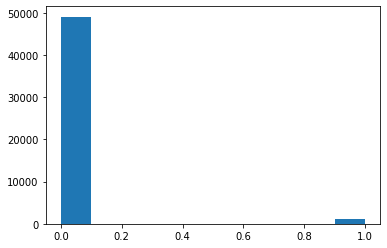

In [130]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

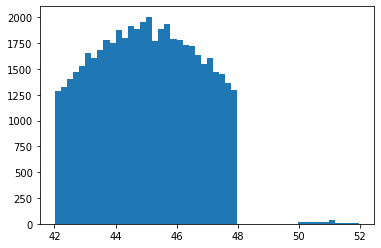

In [131]:
plt.hist(df['Temp'],bins=50)
plt.show()

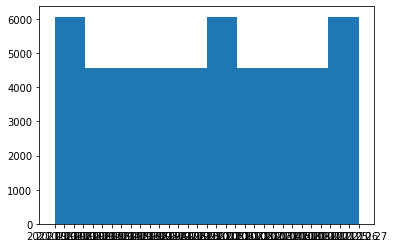

In [132]:
plt.hist(df['date'])
plt.show()

In [133]:
np.array(df).shape

(50094, 8)

# 시간 변환 

In [148]:
set(df['Time'].apply(lambda x: x.split(' ')).apply(lambda x: x[0]).values)
#오후만 있는 것 확인 

{'오후'}

In [165]:
max = np.max(df['Time'].apply(lambda x : x.split(' ')[1].split(':')[1]))
min = np.min(df['Time'].apply(lambda x : x.split(' ')[1].split(':')[1]))
print(max,min)

59 00


- 시간의 차이가 1이 날 경우 마지막꺼에 60분 더해서 차 계산 
- 시간의 차이가 0이 날 경우 그냥 차 계산 

In [211]:
def cal_time(df,date,Lot):
  temp_df = df.loc[(df['date'] == date)&(df['Lot']==Lot)]
  init_hour = int(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[0]).iloc[0])
  finish_hour = int(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[0]).to_numpy()[-1])

  init_minute = int(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[1]).iloc[0])
  finish_minute = int(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[1]).to_numpy()[-1])

  init_second = int(float(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[2]).iloc[0]))
  finish_second = int(float(temp_df['Time'].apply(lambda x :x.split(' ')[1].split(':')[2]).to_numpy()[-1]))

  init_time = init_hour*60*60 + init_minute*60 + init_second
  finish_time = finish_hour*60*60 + finish_minute*60 + finish_second
  process_time = finish_time - init_time
  return process_time

In [228]:
date_lists = list(set(df['date'].values))
Lot_lists = list(set(df['Lot']))
date_lists.sort()
Lot_lists.sort()

In [229]:
time_lists = []
for date in date_lists:
  for Lot in Lot_lists:
    temp_time = cal_time(df,date,Lot)
    time_lists.append([date,Lot,temp_time])
time_lists = pd.DataFrame(time_lists)

In [231]:
len(time_lists)

726

In [240]:
time_lists

,0,1,2
0,2021.09.06,1,340
1,2021.09.06,2,340
2,2021.09.06,3,340
3,2021.09.06,4,341
4,2021.09.06,5,341
...,...,...,...
721,2021.10.27,18,340
722,2021.10.27,19,340
723,2021.10.27,20,340
724,2021.10.27,21,340


In [241]:
error.iloc[1,:]

Index             2
Date     2021.09.07
LoT            13.0
LoT2            0.0
Name: 1, dtype: object

In [243]:
time_lists[(time_lists[0]=='2021.09.07')&(time_lists[1]==13)]

,0,1,2
34,2021.09.07,13,340


# 전처리

## 편차 게산 

편차 계산을 위한 각 변수들 평균 계산 

In [36]:
columns = ['pH','Temp','Current']
mean_values = np.array(df[columns]).mean(axis=0).astype(np.int)
print('Ph = ' ,mean_values[0])
print('Temp = ', mean_values[1])
print('Current = ', mean_values[2])

Ph =  10
Temp =  45
Current =  7


In [50]:
def diff_cal(columns,values):
  if columns == 'pH':
    return_value = abs(10-values)
  if columns == 'Temp':
    return_value = abs(45-values)
  if columns == 'Current' :
    return_value = abs(7-values)
  return return_value

In [55]:
df['Current_diff'] = df['Current'].apply(lambda x : diff_cal('Current',x))
df['Temp_diff'] = df['Temp'].apply(lambda x : diff_cal('Temp',x))
df['pH_diff'] = df['pH'].apply(lambda x : diff_cal('pH',x))

In [58]:
df.head()

,Index,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0,0.34,2.13,0.37
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0,1.26,2.30,0.90
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0,1.46,2.63,0.39
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0,1.04,0.85,0.32
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0,0.23,0.82,0.36


## 컬럼제거

In [59]:
input = np.array(df[['pH_diff','Temp_diff','Current_diff','error']])
input

array([[0.37, 2.13, 0.34, 0.  ],
       [0.9 , 2.3 , 1.26, 0.  ],
       [0.39, 2.63, 1.46, 0.  ],
       ...,
       [0.14, 1.54, 1.15, 0.  ],
       [0.52, 2.88, 0.97, 0.  ],
       [0.97, 1.98, 1.98, 0.  ]])

## 시계열 분할 

In [60]:
input = input.reshape(-1,69,4)
input.shape

(726, 69, 4)

output 제작

In [61]:
output = np.zeros(726)
for index in range(726):
  temp = input[index]
  if temp[:,3].sum()==69:
    output[index]=1

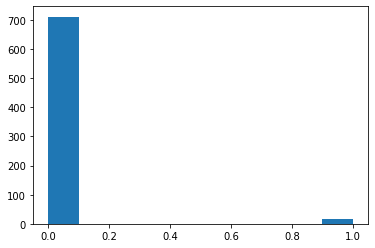

In [62]:
plt.hist(output)
plt.show()

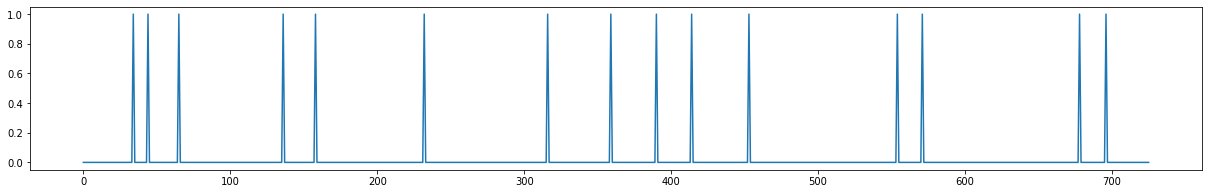

In [63]:
plt.figure(figsize = (21,3))
plt.plot(np.arange(len(output)),output)
plt.show()

train : 450, valid 100, test rest 

## Train - test - valid 분할 

In [64]:
print(input.shape,output.shape)

(726, 69, 4) (726,)


In [65]:
input = input[:,:,:3]

In [66]:
train_x = input[:450]
train_y = output[:450]

valid_x = input[450:550]
valid_y = output[450:550]

test_x = input[550:]
test_y = output[550:]

## min max scaling 

In [67]:
train_x.shape

(450, 69, 3)

In [68]:
max = np.max(np.max(np.concatenate([train_x,valid_x]),axis=0),axis=0)
min = np.min(np.min(np.concatenate([train_x,valid_x]),axis=0),axis=0)
print(max,min)

[1.99 6.95 1.99] [0.   0.   0.01]


In [69]:
def scaling(df,max,min):
  scaled_df = (df-min)/(max-min)
  return scaled_df

In [ ]:
train_x

In [71]:
train_x = scaling(train_x,max,min)
valid_x = scaling(valid_x,max,min)
test_x = scaling(test_x,max,min)

#모델

In [72]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

In [246]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=20)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=20,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [model_check_point, plot_losses, reduce_lr]

In [248]:
#Env 데이터 파트 
input = Input((69,3)) #<---- shape 
x = Bidirectional(LSTM(128,return_sequences= True))(input) #bidirec
x = Bidirectional(LSTM(128))(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dense(32, activation ='relu')(x)
x = BatchNormalization()(x)
output = Dense(2,activation = 'softmax')(x)

model = Model(input,output)

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics = ['accuracy'],)

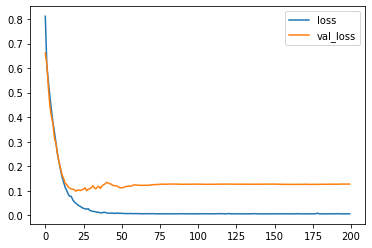

loss =  0.006229306571185589 , val_loss =  0.12722663581371307
13/13 [==============================] - 0s 39ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.1272 - val_accuracy: 0.9778 - lr: 2.5600e-09


In [249]:
model.fit(train_x,train_y, epochs=200, verbose=1, batch_size=32, validation_split=0.1,callbacks=callbacks)

# 예측

In [76]:
test_y[test_y==1]

array([1., 1., 1., 1.])

## train 정상 - 비정상 max softmax score 분포 확인 

In [250]:
normal_index = np.where(train_y!=1)
y_ = model.predict(train_x[normal_index])
normal_predicted = np.max(y_,axis=1) # max softmax score 

anormal_index = np.where(train_y==1)
y_ = model.predict(train_x[anormal_index])
anormal_predicted = np.max(y_,axis=1) # max softmax score 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'normal - anormal'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


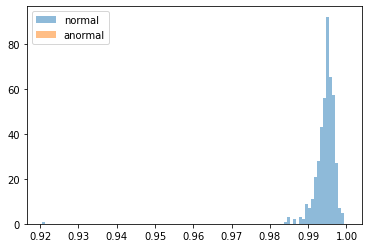

In [251]:
plt.hist(normal_predicted, bins=100, alpha = 0.5, label='normal')
plt.hist(anormal_predicted, bins=100, alpha = 0.5, label='anormal')
plt.legend(loc='normal - anormal')

plt.show()

## Test 데이터 예측 

In [252]:
y_ = model.predict(test_x)
test_predicted = np.max(y_,axis=1) # max softmax score 

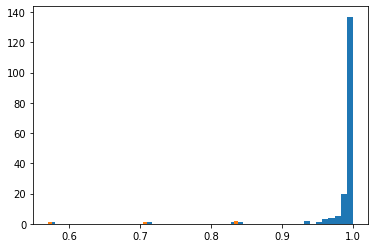

In [253]:
plt.hist(test_predicted,bins=50)
plt.hist(test_predicted[test_predicted<0.9],bins=50)
plt.show()

In [259]:
print('이상이라 판단한 예측 값 = ',np.where(test_predicted<0.8))
print('              실제 이상 = ',np.where(test_y==1))

이상이라 판단한 예측 값 =  (array([101, 146]),)
              실제 이상 =  (array([  4,  21, 128, 146]),)


## Test의 이상 분포 확인 

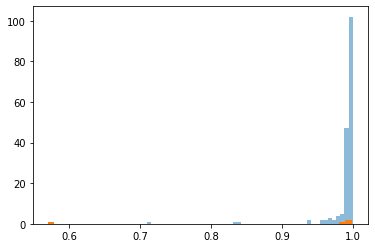

In [255]:
#이상 
anormal_test_predicted = model.predict(test_x[np.where(test_y==1)])
anormal_test_predicted = np.max(anormal_test_predicted,axis=1)
normal_test_predicted = model.predict(test_x[np.where(test_y==0)])
normal_test_predicted = np.max(normal_test_predicted,axis=1)

plt.hist(normal_test_predicted,bins=50,alpha = 0.5)
plt.hist(anormal_test_predicted,bins=50)
plt.show()

그나마 도출할 수 있는 결과는 편차를 이용한 변수를 만들어서 정상 값들의 분포가 
모여짐 
- 이를 기반으로 시간 진행 

아래 사진은 Baseline의 Test 데이터 max softmax score distribution

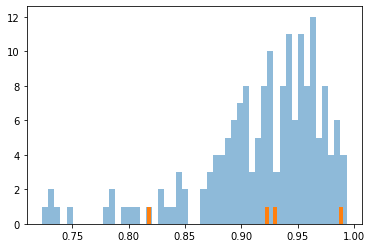